Loading EEG dataset features...
Data loaded. Training set: (3428, 6), Test set: (1470, 6)

TASK A1 & A2: CALCULATING IMPURITY METRICS ON TRAINING DATA
Entropy of training labels: 0.9999
Gini index of training labels: 0.5000

TASK A3 & A4: FINDING BEST FEATURE FOR ROOT NODE SPLIT
Information Gain for each feature (top 5 shown):
          Feature  Information Gain
1  CSP_Feature_1          0.003990
5  CSP_Feature_5          0.002670
4  CSP_Feature_4          0.002389
2  CSP_Feature_2          0.001299
3  CSP_Feature_3          0.001016

Conclusion: Best feature for the root node is 'CSP_Feature_1' with IG = 0.0040

EVALUATING MODEL: Unpruned Decision Tree (Overfit)

--- Performance on Training Data ---
Accuracy: 1.0000

--- Performance on Test Data ---
Accuracy: 0.5367

              precision    recall  f1-score   support

   Left Fist       0.54      0.57      0.55       741
  Right Fist       0.54      0.50      0.52       729

    accuracy                           0.54      1470
   

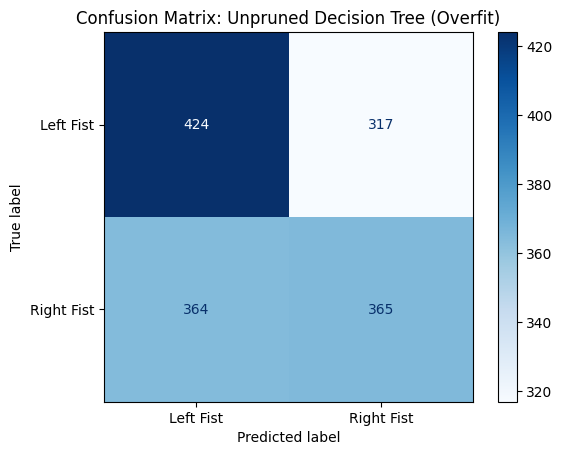


EVALUATING MODEL: Pruned Decision Tree (max_depth=4)

--- Performance on Training Data ---
Accuracy: 0.5834

--- Performance on Test Data ---
Accuracy: 0.5306

              precision    recall  f1-score   support

   Left Fist       0.53      0.55      0.54       741
  Right Fist       0.53      0.51      0.52       729

    accuracy                           0.53      1470
   macro avg       0.53      0.53      0.53      1470
weighted avg       0.53      0.53      0.53      1470



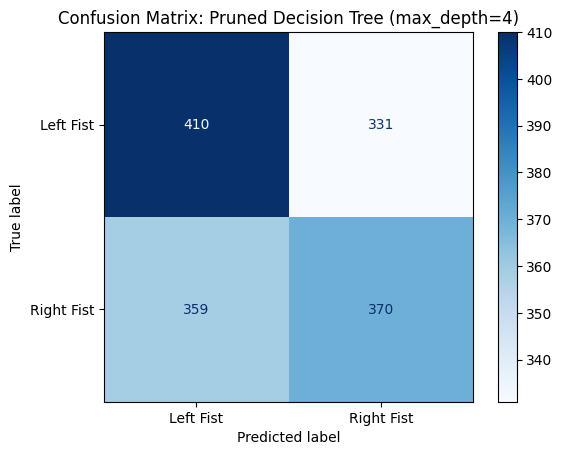


TASK A6: VISUALIZING THE PRUNED DECISION TREE


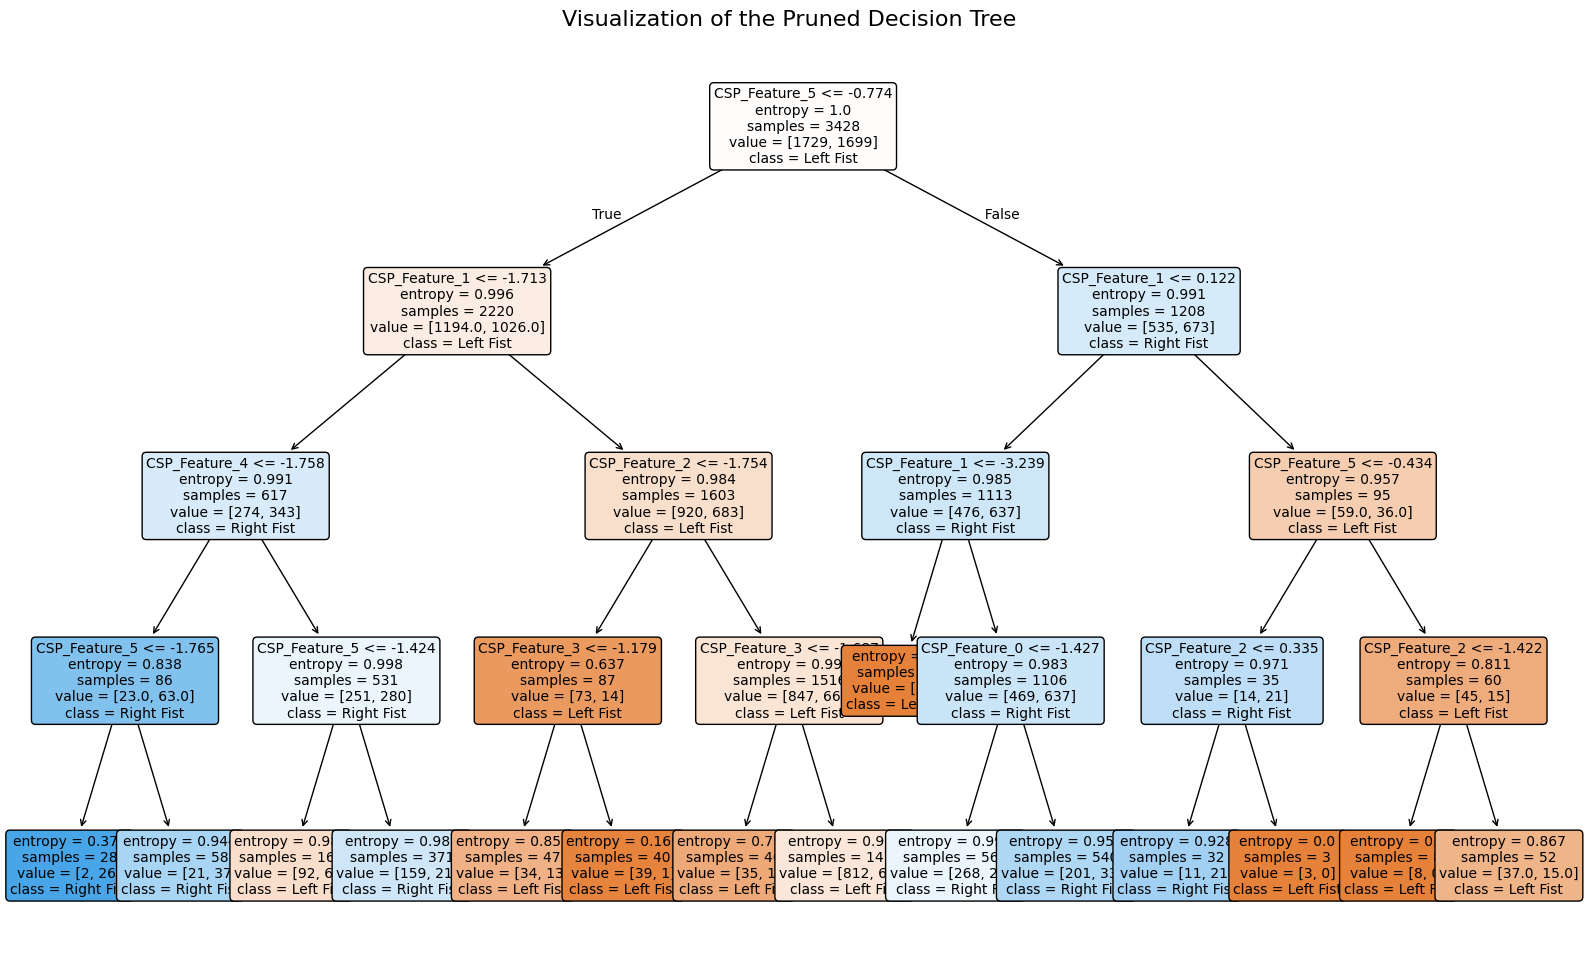

C:\Users\samee\AppData\Local\Temp\ipykernel_26920\116589519.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importances, palette='viridis')


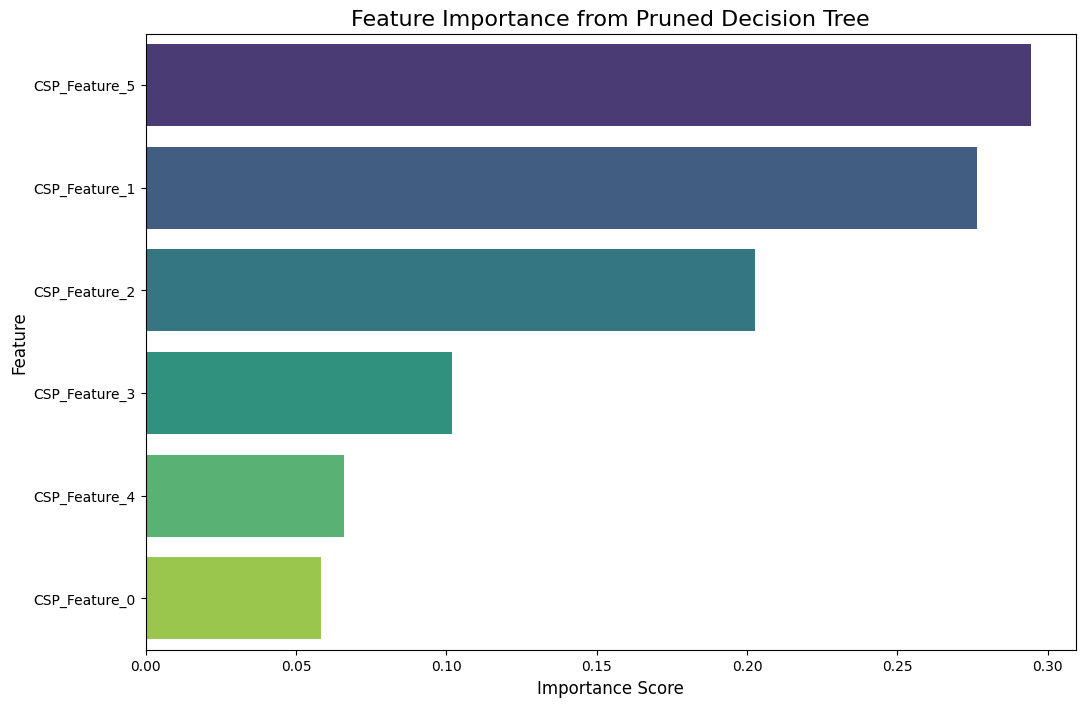


ENHANCEMENT: 5-FOLD CROSS-VALIDATION ON PRUNED MODEL
Individual fold accuracies: ['0.5347', '0.4796', '0.4663', '0.5169', '0.5414']
Mean CV Accuracy: 0.5078 (± 0.0298)

TASK A7: PLOTTING ENHANCED 2D DECISION BOUNDARY
Retraining model on the first two features for visualization purposes...


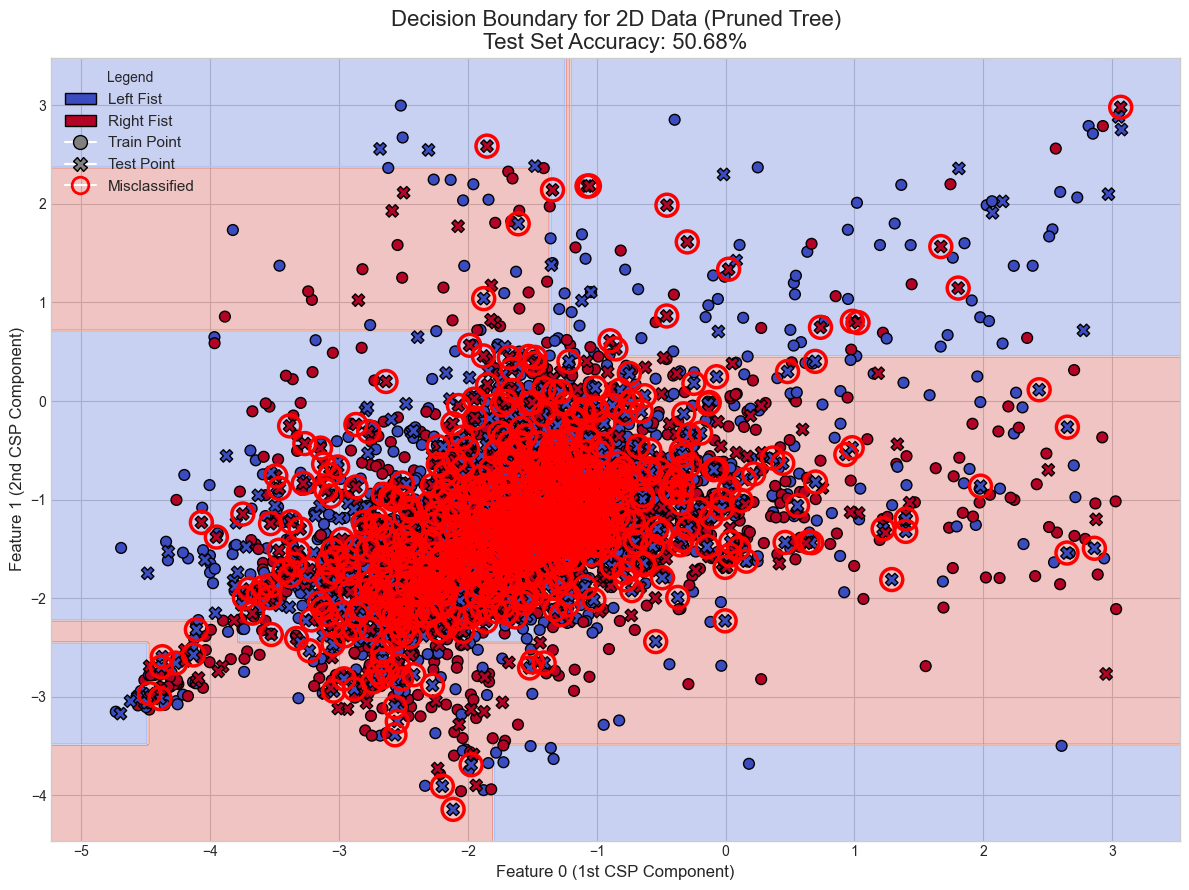

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Tuple, Dict

# Scikit-learn imports for modeling and evaluation
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Imports for the enhanced A7 plot
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ================================
# CONFIG
# ================================
FEATURES_SAVE_ROOT: str = r"C:\Users\samee\Downloads\EEG_Features"
TEST_SIZE: float = 0.3
RANDOM_STATE: int = 42
N_BINS: int = 5  # Number of bins for discretizing continuous features
CV_FOLDS: int = 5  # Number of folds for cross-validation
CLASS_NAMES: Dict[int, str] = {1: "Left Fist", 2: "Right Fist"} # Descriptive names for labels

# ================================
# DATA LOADING
# ================================
def load_all_features(feature_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads all feature files and concatenates them into single arrays."""
    all_features = []
    all_labels = []
    subject_files = sorted([f for f in os.listdir(feature_path) if f.endswith('_features.npz')])
    if not subject_files:
        raise FileNotFoundError(f"No feature files found in '{feature_path}'.")
    for filename in subject_files:
        filepath = os.path.join(feature_path, filename)
        data = np.load(filepath)
        all_features.append(data['features'])
        all_labels.append(data['labels'])
    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

# ================================
# A1. ENTROPY + BINNING
# ================================
def equal_width_binning(data: np.ndarray, n_bins: int = 4) -> np.ndarray:
    """Discretizes continuous data into equal-width bins."""
    bins = np.linspace(np.min(data), np.max(data), n_bins + 1)
    # Ensure the last bin includes the max value
    bins[-1] = bins[-1] + 1 
    return np.digitize(data, bins[:-1], right=False)

def entropy(y: np.ndarray) -> float:
    """Calculates the entropy of a set of labels."""
    if len(y) == 0:
        return 0
    counts = Counter(y)
    probs = [c / len(y) for c in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

# ================================
# A2. GINI INDEX
# ================================
def gini_index(y: np.ndarray) -> float:
    """Calculates the Gini index of a set of labels."""
    if len(y) == 0:
        return 0
    counts = Counter(y)
    probs = [c / len(y) for c in counts.values()]
    return 1 - sum(p**2 for p in probs)

# ================================
# A3 & A4. INFORMATION GAIN
# ================================
def information_gain(X_col: np.ndarray, y: np.ndarray, n_bins: int) -> float:
    """Calculates the information gain from splitting y based on a single feature."""
    # Discretize the continuous feature column for IG calculation
    X_col_binned = equal_width_binning(X_col, n_bins=n_bins)
    
    total_entropy = entropy(y)
    values, counts = np.unique(X_col_binned, return_counts=True)
    
    weighted_entropy = sum(
        (c / len(X_col_binned)) * entropy(y[X_col_binned == v])
        for v, c in zip(values, counts)
    )
    return total_entropy - weighted_entropy

def find_best_feature(X: np.ndarray, y: np.ndarray, n_bins: int) -> Tuple[int, float, List[float]]:
    """Finds the feature with the highest information gain."""
    gains = [information_gain(X[:, i], y, n_bins) for i in range(X.shape[1])]
    best_idx = np.argmax(gains)
    return best_idx, gains[best_idx], gains

# ================================
# A5. BUILD DECISION TREE & ENHANCED EVALUATION
# ================================
def build_and_evaluate_tree(X_train, y_train, X_test, y_test, title: str, **kwargs):
    """Builds, trains, and comprehensively evaluates a decision tree."""
    print("\n" + "="*80)
    print(f"EVALUATING MODEL: {title}")
    print("="*80)
    
    # Build and train the model
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, **kwargs)
    model.fit(X_train, y_train)
    
    # --- Evaluate on Training Data (to check for overfitting) ---
    print("\n--- Performance on Training Data ---")
    y_train_pred = model.predict(X_train)
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    
    # --- Evaluate on Test Data ---
    print("\n--- Performance on Test Data ---")
    y_test_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}\n")
    
    # Full classification report
    print(classification_report(y_test, y_test_pred, target_names=[CLASS_NAMES[c] for c in np.unique(y)]))
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test,
        display_labels=[CLASS_NAMES[c] for c in model.classes_],
        cmap=plt.cm.Blues
    )
    plt.title(f"Confusion Matrix: {title}")
    plt.show()
    
    return model

# ================================
# ENHANCED: FEATURE IMPORTANCE & VISUALIZATION
# ================================
def plot_feature_importance(model: DecisionTreeClassifier, feature_names: List[str]):
    """Plots the feature importances from a trained tree-based model."""
    importances = model.feature_importances_
    df_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=df_importances, palette='viridis')
    plt.title('Feature Importance from Pruned Decision Tree', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

# =========================================================================
# A7. ENHANCED DECISION BOUNDARY VISUALIZATION (2 FEATURES)
# =========================================================================
def plot_enhanced_decision_boundary(model, X_train, y_train, X_test, y_test, class_names):
    """
    Plots a highly informative 2D decision boundary, showing train/test points
    and highlighting misclassifications on the test set.
    """
    # Make predictions on the 2D test set to identify errors
    y_pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    
    # Find the indices of misclassified points
    misclassified_idx = np.where(y_test != y_pred_test)[0]

    # Create a meshgrid for the background contour plot
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict the class for each point in the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))
    
    # Plot the decision boundary regions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Plot the training data points (solid circles)
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, 
        edgecolor='k', s=60, marker='o', label='Train Data'
    )
    
    # Plot the test data points (X markers)
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, 
        edgecolor='k', s=80, marker='X', label='Test Data'
    )

    # Highlight the misclassified points with a red circle
    plt.scatter(
        X_test[misclassified_idx, 0], X_test[misclassified_idx, 1],
        s=250, facecolors='none', edgecolors='red', linewidth=2.5,
        label='Misclassified'
    )
    
    # --- Set Titles and Labels ---
    plt.title(
        f"Decision Boundary for 2D Data (Pruned Tree)\nTest Set Accuracy: {accuracy*100:.2f}%", 
        fontsize=16
    )
    plt.xlabel("Feature 0 (1st CSP Component)", fontsize=12)
    plt.ylabel("Feature 1 (2nd CSP Component)", fontsize=12)
    
    # --- Create a Comprehensive Custom Legend ---
    unique_classes = np.unique(y_train)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_classes)))
    
    legend_elements = [
        Patch(facecolor=colors[i], edgecolor='k', label=class_names[cls]) for i, cls in enumerate(unique_classes)
    ]
    legend_elements.extend([
        Line2D([0], [0], marker='o', color='w', label='Train Point', markerfacecolor='gray', markeredgecolor='k', markersize=10),
        Line2D([0], [0], marker='X', color='w', label='Test Point', markerfacecolor='gray', markeredgecolor='k', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Misclassified', markerfacecolor='none', markeredgecolor='red', markersize=12, markeredgewidth=2)
    ])

    plt.legend(handles=legend_elements, title="Legend", loc='best', fontsize=11)
    plt.tight_layout()
    plt.show()

# ================================
# MAIN EXECUTION
# ================================
if __name__ == "__main__":
    
    # --- Load and prepare data ---
    print("Loading EEG dataset features...")
    X, y = load_all_features(FEATURES_SAVE_ROOT)
    feature_names = [f"CSP_Feature_{i}" for i in range(X.shape[1])]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    print(f"Data loaded. Training set: {X_train.shape}, Test set: {X_test.shape}")

    # --- A1 & A2: Calculate Entropy and Gini Index ---
    print("\n" + "="*80)
    print("TASK A1 & A2: CALCULATING IMPURITY METRICS ON TRAINING DATA")
    print("="*80)
    print(f"Entropy of training labels: {entropy(y_train):.4f}")
    print(f"Gini index of training labels: {gini_index(y_train):.4f}")

    # --- A3 & A4: Find Best Feature using Information Gain ---
    print("\n" + "="*80)
    print("TASK A3 & A4: FINDING BEST FEATURE FOR ROOT NODE SPLIT")
    print("="*80)
    best_idx, best_gain, all_gains = find_best_feature(X_train, y_train, n_bins=N_BINS)
    df_gains = pd.DataFrame({'Feature': feature_names, 'Information Gain': all_gains}).sort_values(by='Information Gain', ascending=False)
    print("Information Gain for each feature (top 5 shown):\n", df_gains.head())
    print(f"\nConclusion: Best feature for the root node is '{feature_names[best_idx]}' with IG = {best_gain:.4f}")
    
    # --- A5 (Part 1): Build and evaluate an UNPRUNED tree to see overfitting ---
    model_unpruned = build_and_evaluate_tree(
        X_train, y_train, X_test, y_test,
        title="Unpruned Decision Tree (Overfit)",
        criterion="entropy" # No max_depth
    )

    # --- A5 (Part 2): Build and evaluate a PRUNED tree to improve generalization ---
    model_pruned = build_and_evaluate_tree(
        X_train, y_train, X_test, y_test,
        title="Pruned Decision Tree (max_depth=4)",
        criterion="entropy",
        max_depth=4
    )

    # --- A6: Visualize the (more interpretable) PRUNED tree ---
    print("\n" + "="*80)
    print("TASK A6: VISUALIZING THE PRUNED DECISION TREE")
    print("="*80)
    plt.figure(figsize=(20, 12))
    plot_tree(model_pruned, filled=True, feature_names=feature_names, class_names=[CLASS_NAMES[c] for c in model_pruned.classes_], rounded=True, fontsize=10)
    plt.title("Visualization of the Pruned Decision Tree", fontsize=16)
    plt.show()

    # --- ENHANCEMENT: Plot Feature Importance from the Pruned Tree ---
    plot_feature_importance(model_pruned, feature_names)

    # --- ENHANCEMENT: Robust Evaluation with K-Fold Cross-Validation ---
    print("\n" + "="*80)
    print(f"ENHANCEMENT: {CV_FOLDS}-FOLD CROSS-VALIDATION ON PRUNED MODEL")
    print("="*80)
    # Re-initialize the model to ensure a fair CV
    pruned_model_for_cv = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(pruned_model_for_cv, X, y, cv=CV_FOLDS, scoring='accuracy')
    print(f"Individual fold accuracies: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (± {np.std(cv_scores):.4f})")
    
    # --- A7: Decision Boundary Plot ---
    print("\n" + "="*80)
    print("TASK A7: PLOTTING ENHANCED 2D DECISION BOUNDARY")
    print("="*80)
    print("Retraining model on the first two features for visualization purposes...")
    
    # Prepare the 2D data
    X_train_2d = X_train[:, :2]
    X_test_2d = X_test[:, :2]
    
    # Train a new model specifically on the 2D data
    model_2d = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=RANDOM_STATE)
    model_2d.fit(X_train_2d, y_train)
    
    # Call the enhanced plotting function
    plot_enhanced_decision_boundary(model_2d, X_train_2d, y_train, X_test_2d, y_test, CLASS_NAMES)